In [ ]:
git clone https://github.com/adriencances/TimeSeriesProject.git

Place the notebook in the folder **mStamp**

In [4]:
import time
import numpy as np
import scipy
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mstamp_stamp import mstamp
from mstamp_stomp import mstamp as mstamp_stomp
from mstamp_RMSEs import compute_mstamp_RMSEs
from plot_motifs import plot_motifs
from bits_compression import MDL

# Utility Functions

In [ ]:
def plot_motifs(matrix_profile, data, sub_len, dimensionality=1, profile=None):
    motif_at = matrix_profile[dimensionality - 1, :].argsort()[:2]
    
    nb_dims, length = data.shape
    plt.figure(figsize=(20, 10))
    if profile is not None:
        t_1_index = profile[:,motif_at[0]]
        dims = t_1_index
    else:
        dims = np.arange(nb_dims)
    nb_dims = len(dims)
    k = 0
    for i in dims:
        plt.subplot(nb_dims+1,1,k+1)
        plt.plot(data[i])
        plt.title(f"$T_{i+1}$")
        for m in motif_at:
            plt.plot(range(m,m+sub_len), data[i][m:m+sub_len], c='r')
        # plt.xlim((0, matrix_profile.shape[1]))
        plt.xlim((0, length))
        k += 1

    plt.subplot(nb_dims+1, 1, nb_dims+1)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality-1, :])
    for m in motif_at:
        plt.axvline(m, c='r')
    # plt.xlim((0, matrix_profile.shape[1]))
    plt.xlim((0, length))
    plt.tight_layout()

In [ ]:
def Dnorm(T):
    """Normalize the time series T

    Parameters:
        T: np.array(m, dim_selected)

    Return:
        normalized sequence
    """
    m, dim = T.shape
    maxi = np.max(T, axis=0)
    mini = np.min(T, axis=0)
    b = int(T.nbytes/(m*dim))
    normalized = (T-mini[None,:])/(maxi[None,:] - mini[None,:])*(np.power(2, b) - 1) + 1
    return normalized.astype(int) + 1

def DL(T):
    """compute DL of T
    T must be normalized

    Parameters:
        T: np.array(m, dim_selected)

    Return:
        DL score of T
    """
    m, dim = T.shape
    return T.nbytes*8/dim

def RDL(t_c, t_h):
    """compute RDL of t_c according to t_h
    t_c and t_h must be normalized
    the bit number encoding b of t_c and t_h must be equal

    Parameters:
        t_c: np.array(m, dim_selected)
        t_h: np.array(m, dim_selected)

    Return:
        RDL score between t_c and t_h
    """
    diff = t_c - t_h
    gamma = np.sum(diff != 0)
    m, dim = t_c.shape
    b = int(t_c.nbytes/(m*dim))*8
    # b = int(t_c.nbytes/(m*dim))
    return gamma*(np.log2(m) + b)/dim

def bit(time_series, compressible_set_index, hypothesis_index, sub_len, unexplored_index=None):
    """Compute the bits required to store compressible_set_index according to hypothesis_index

    Parameters:
        time_series: list of index
        compressible_set_index: list of index
        hypothesis_index: list of index
        sub_len: int
        unexplored_index: list of index

    Return:
        number of bits necessary for compression using the article of Yeh,C.-C.M.,VanHerle,H.,andKeogh
    """
    compressible_set = []
    hypothesis_set = []
    for idx, prof in compressible_set_index:
        compressible_set.append(Dnorm(time_series[idx: idx + sub_len, prof]))
    for idx, prof in hypothesis_index:
        hypothesis_set.append(Dnorm(time_series[idx: idx + sub_len, prof]))
    h = len(hypothesis_set)
    res = 0
    for t_c in compressible_set:
        min_rdl = RDL(t_c, hypothesis_set[0])
        for i in range(1, h):
            rdl = RDL(t_c, hypothesis_set[i])
            if rdl <= min_rdl:
                min_rdl = rdl
        res += min_rdl
    for t_h in hypothesis_set:
        res += DL(t_h)
    if unexplored_index is not None:
        for t_u in unexplored_index:
            res += DL(t_u)
    return res

def MDL(matrix_profile, time_series, sub_len, profile):
    """mdl methods, compute the bits that are needed to store the
    two subsequences selected for each dimension

    Parameters:
        matrix_profil: np.array (n_dim, m)
        time_series: np.array (m, n_dim)
        sub_len: int
        profile: list of int (n_dim lists)

    Return:
        compression value for each dimension computed with RDL
    """
    dimension = matrix_profile.shape[0]
    bits = []
    for d in range(dimension):
        t_1, t_2 = matrix_profile[d, :].argsort()[:2]
        hypothesis_index = [(t_1, profile[d][:,t_1])]
        compressible_set_index = [(t_2, profile[d][:,t_2])]
        bits.append(bit(time_series, compressible_set_index, hypothesis_index, sub_len))
    return np.array(bits)

# Toy dataset

This small dataset was included in the GiHub repository of mSTAMP.
It is an artificial time series of dimension $3$ with length $550$.
The pro of this toy dataset is that the motif is clearly visible and occurs on the second and third dimensions.

In [5]:
def load_toy_data_and_sublen():
    mat = io.loadmat('toy_data.mat')
    sub_len = mat["sub_len"].item()
    time_series = mat["data"].transpose(1,0)
    return time_series, sub_len

On this example, we can easily check that the mSTAMP algorithm finds the same motifs, even when part of the time series has been shifted and scaled. This is due to the use of the z-normalized distance in the definition of the matrix profile.

with original toy dataset


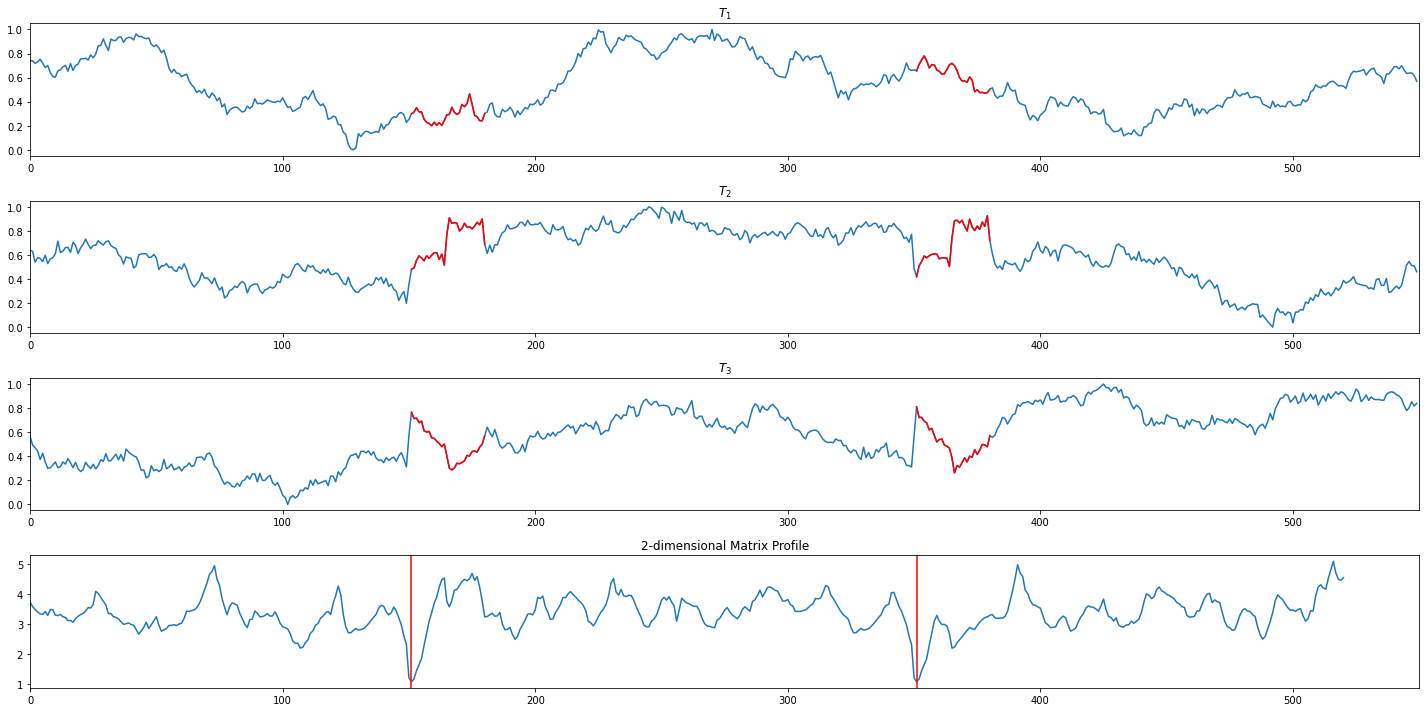

In [6]:
time_series, sub_len = load_toy_data_and_sublen()
mat_pro, pro_idx = mstamp(time_series, sub_len)

plot_motifs(mat_pro, time_series, sub_len, dimensionality=2)
plt.savefig("images/toy_data_orig.png")
print("with original toy dataset")

with part of dataset shifted and rescaled


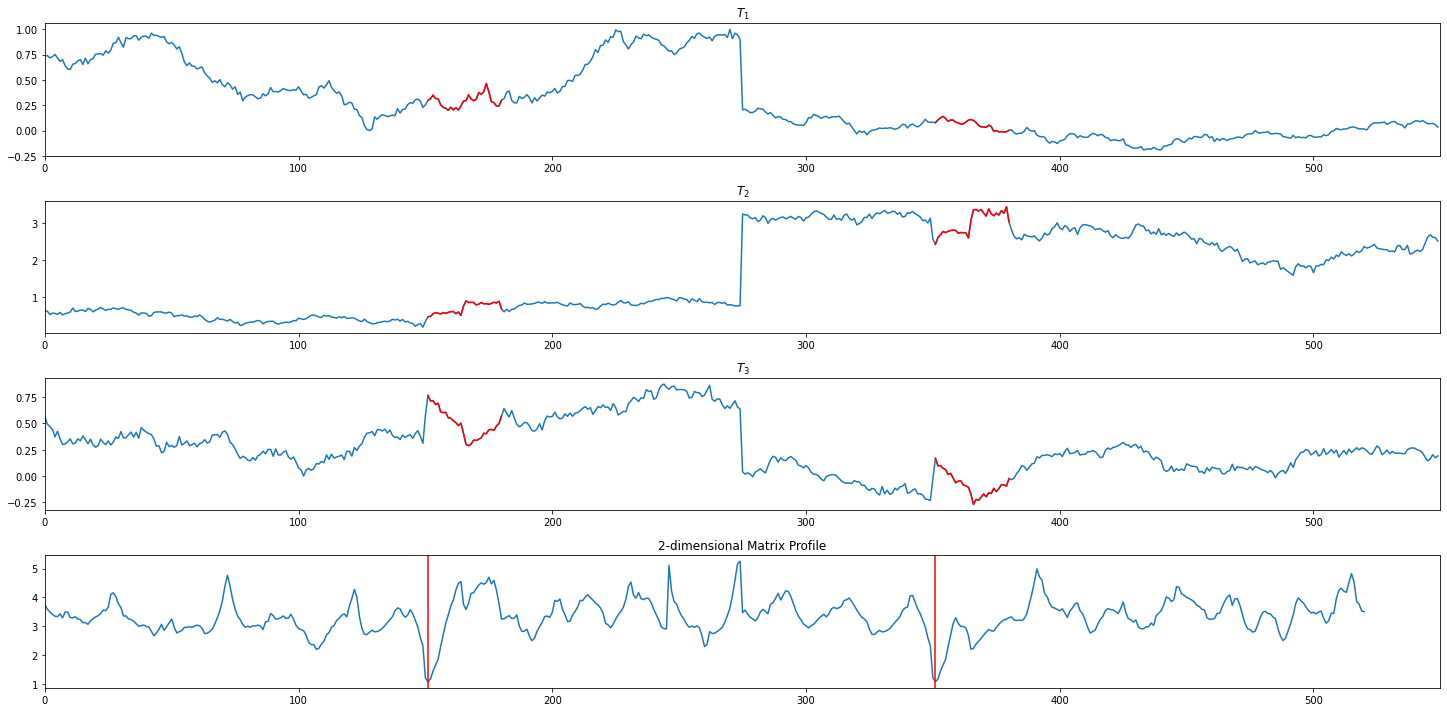

In [7]:
length = time_series.shape[1]
shifts = [-0.5, 0.8, -0.6]
scales = [0.5, 2, 0.8]
for k in range(3):
    time_series[k,length//2:] += shifts[k]
    time_series[k,length//2:] *= scales[k]

mat_pro, pro_idx = mstamp(time_series, sub_len)
plot_motifs(mat_pro, time_series, sub_len, dimensionality=2)
print("with part of dataset shifted and rescaled")
plt.savefig("images/toy_data_shifted_scaled.png")

#  Istanbul stock dataset

This dataset relate returns of Istanbul Stock Exchange with
several other international indices,
from Jun 5, 2009 to Feb 22, 2011, and is organized with regard to working days in Istanbul Stock Exchange.

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


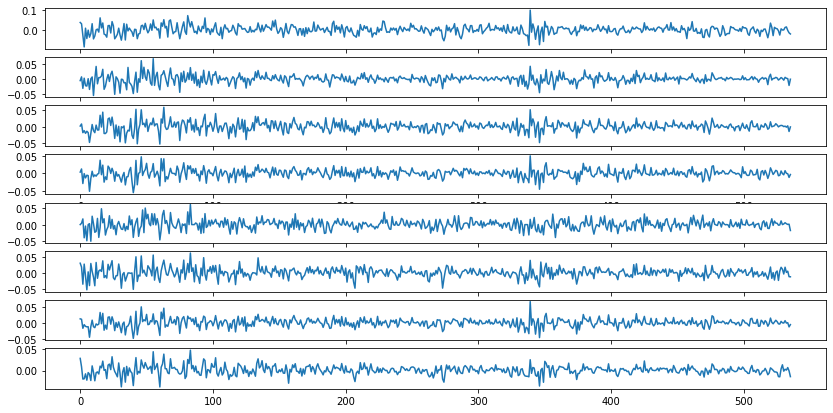

In [8]:
def load_Istanbul_stock():
    data = pd.read_excel("data_akbilgic.xlsx")
    data = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])
    time_series = data.to_numpy().transpose(1,0)
    return time_series

time_series = load_Istanbul_stock()
nb_dims = time_series.shape[0]
fig, axs =  plt.subplots(nb_dims, 1, figsize=(14,7))
for i in range(nb_dims):
    axs[i].plot(time_series[i])
plt.show()

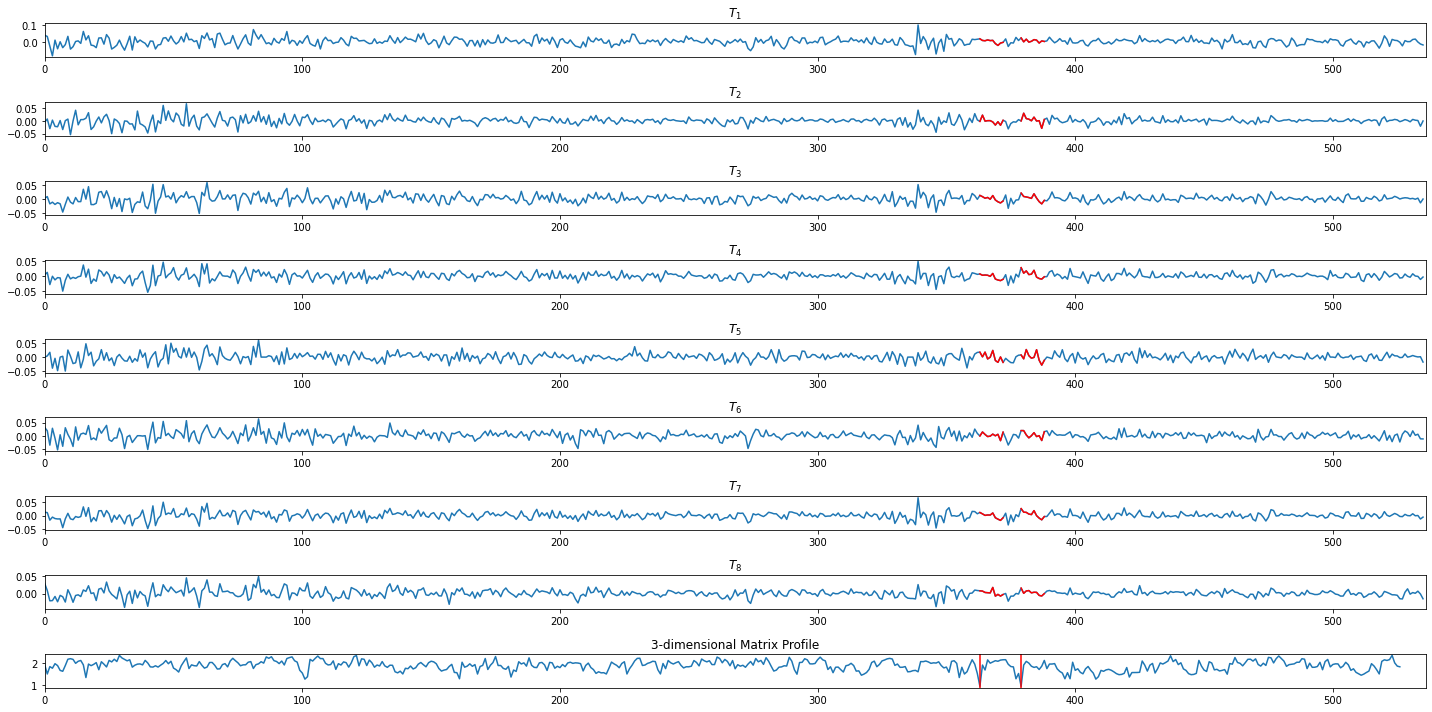

In [9]:
# plot the matrix profil for three dimension
sub_len = 10
mat_pro_approx, pro_idx_approx = mstamp(time_series, sub_len, return_dimension=False)
plot_motifs(mat_pro_approx, time_series, sub_len, dimensionality=3)

# DJIA stock dataset

This dataset contains historical stock data for 30 DJIA companies as well as the total stock, from 2006-01-01 to 2018-01-01.

In [22]:
def load_DJIA_stock():
    all_data = pd.read_csv("DJIA_30_Stock/all_stocks_2006-01-01_to_2018-01-01.csv")
    names = list(set(all_data["Name"].tolist()))

    length = 3019
    dims = len(names)
    final_data = np.zeros((dims, length))
    lens = []
    for k, name in enumerate(names):
        data = np.array(all_data[all_data["Name"] == name]["Open"].tolist())
        mask = np.isnan(data)
        data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
        assert np.any(~np.isnan(data))
        lens.append(len(data))
        final_data[k] = data[:length].copy()

    time_series = final_data
    return time_series

time_series = load_DJIA_stock()


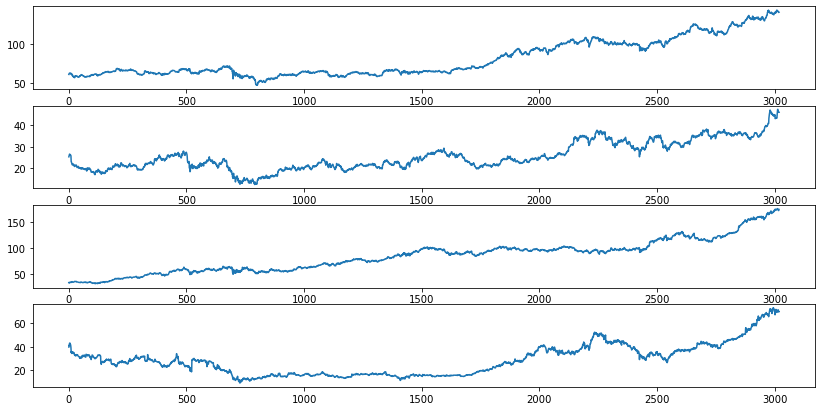

In [23]:
nb_dims_to_show = 4
fig, axs =  plt.subplots(nb_dims_to_show, 1, figsize=(14,7))
for i in range(nb_dims_to_show):
    axs[i].plot(time_series[i])
plt.show()

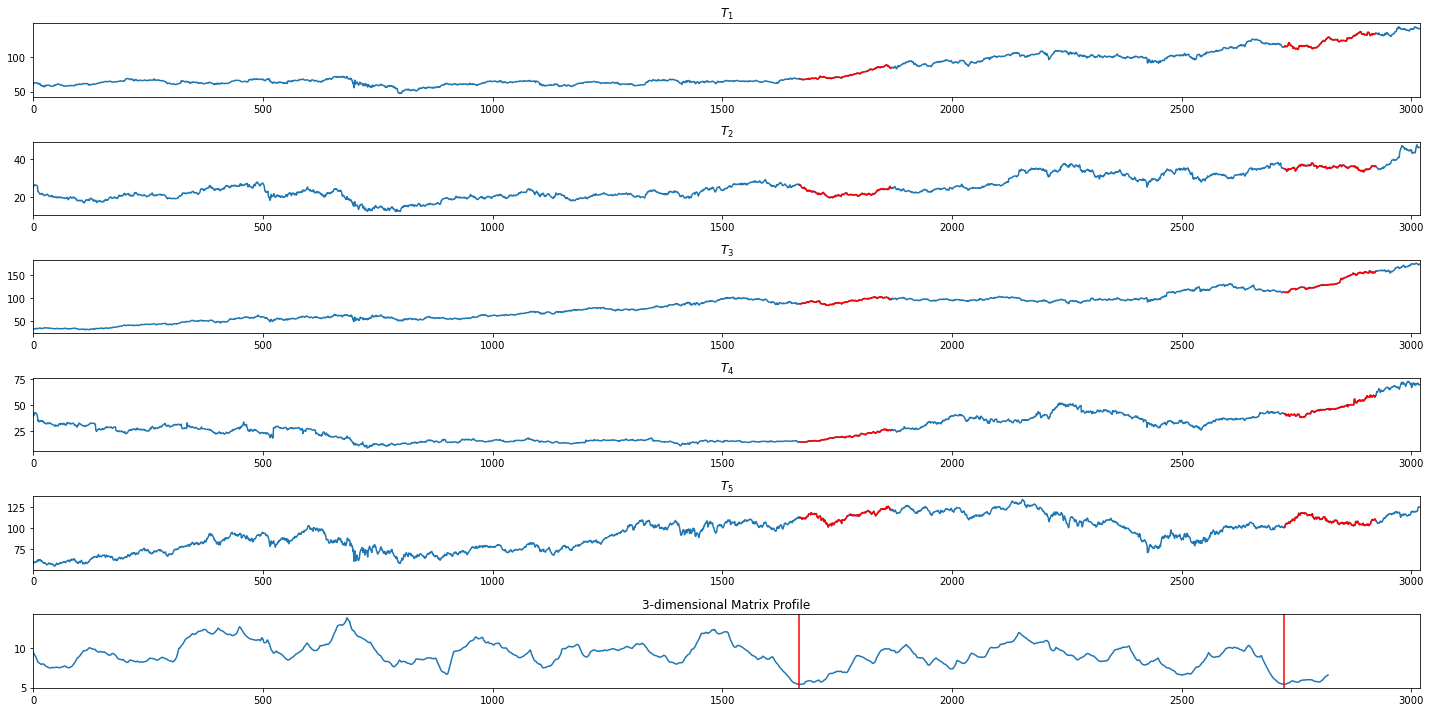

In [24]:
nb_used_dims = 5
sub_len = 200
mat_pro_approx, pro_idx_approx = mstamp(time_series[:nb_used_dims], sub_len, return_dimension=False)
plot_motifs(mat_pro_approx, time_series[:nb_used_dims], sub_len, dimensionality=3)

# Evolution of the RMSEs throughout the iterations

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


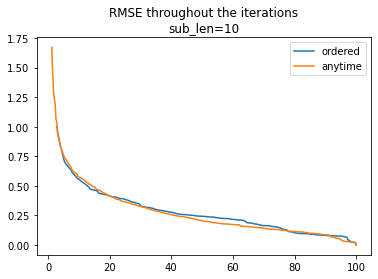

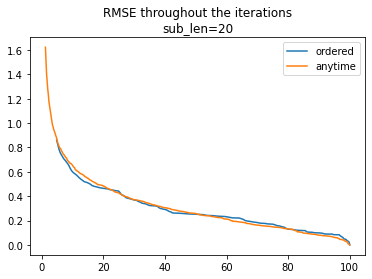

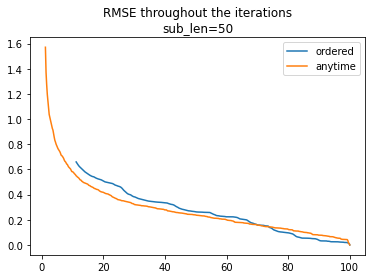

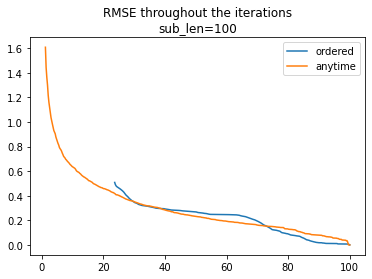

In [28]:
time_series = load_Istanbul_stock()

sub_len = 10
for sub_len in [10, 20, 50, 100]:
    mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
    RMSEs = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=False)
    RMSEs_anytime = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=True)

    length = time_series.shape[1]
    perc_iters = np.linspace(1,100,length-sub_len+1)
    max_val = max([RMSEs[RMSEs < np.inf].max(),
                RMSEs_anytime[RMSEs_anytime < np.inf].max()])
    plt.figure()
    plt.title(f"RMSE throughout the iterations\nsub_len={sub_len}")
    plt.plot(perc_iters, RMSEs)
    plt.plot(perc_iters, RMSEs_anytime)
    plt.legend(["ordered", "anytime"])
    plt.show()

For this part, we have used the DJIA stock dataset, using only
three dimensions, but with full length, i.e. $3019$ timestamps.
We have recorded the Root Mean Squared Error (RMSE) between
the true matrix profile and the current "best-so-far" matrix profile
throughout the iterations, both for the ordered version of
the mSTAMP algorithm and for its anytime version (based on
STAMP in both case).

Our experiments seem to show
that the anytime behavior is only interesting for large
enough subsequence lengths.
This is rather easy to understand: the larger the subsequence
length, the easier it is to approximate its distance
to its closest subsequence by using only a part
of the set of all subsequences.

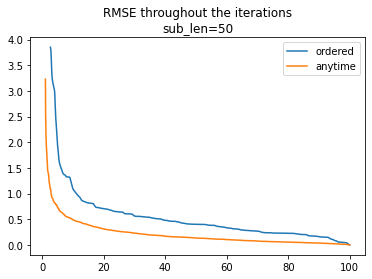

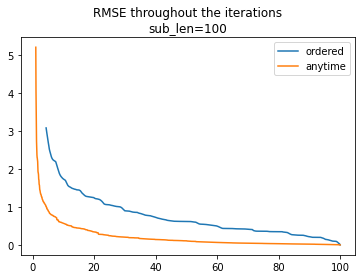

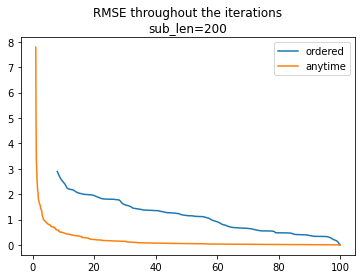

In [94]:
time_series = load_DJIA_stock()
nb_used_dims = 3
time_series = time_series[:nb_used_dims]

for sub_len in [50, 100, 200]:
    length = time_series.shape[1]

    mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
    RMSEs = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=False)
    RMSEs_anytime = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=True)

    perc_iters = np.linspace(1,100,length-sub_len+1)
    max_val = max([RMSEs[RMSEs < np.inf].max(),
                RMSEs_anytime[RMSEs_anytime < np.inf].max()])
    plt.figure()
    plt.title(f"RMSE throughout the iterations\nsub_len={sub_len}")
    plt.plot(perc_iters, RMSEs)
    plt.plot(perc_iters, RMSEs_anytime)
    plt.legend(["ordered", "anytime"])
    plt.savefig(f"images/RMSE_DJIA_3d_sublen{sub_len}.pdf")

The authors of the mSTAMP article claim that the
approximated multidimensional matrix profile achieves
a low Root Mean Square Error (RMSE) when just 10\%
of the iterations are completed.
Our results seem to corroborate this claim
for large enough subsequence lengths.

However, small RMSE does not mean that the approximate matrix profile
allows to recover the motifs.
Indeed, as shown below,
the approximate matrix profile is in fact no so close
to the true matrix profile after $20\%$ of the iterations,
and more importantly, the location of the minimums are not
the same at all.
This means that the motif cannot yet be recovered.

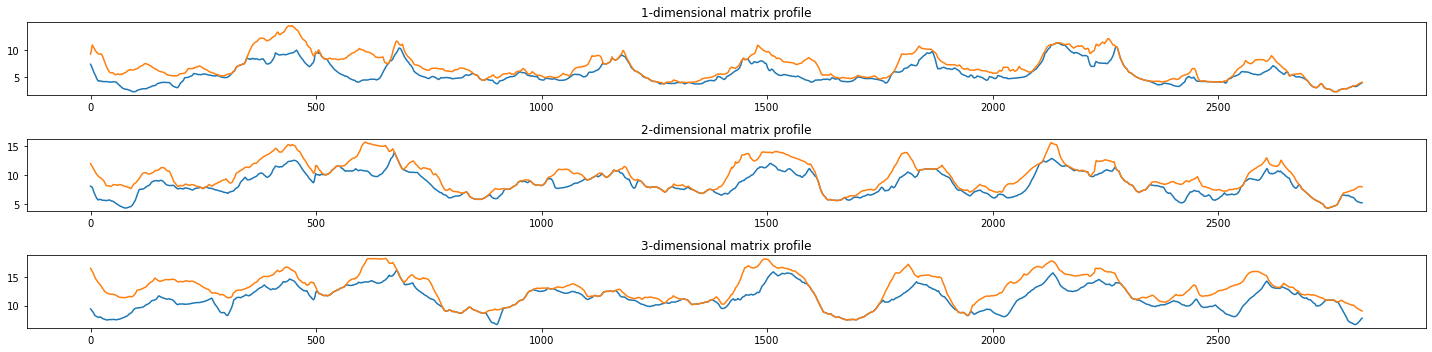

In [52]:
time_series = load_DJIA_stock()
nb_used_dims = 3
time_series = time_series[:nb_used_dims]

sub_len = 200
iter = int(0.2*length-sub_len+1)
mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
mat_pro_approx, _ =  mstamp(time_series, sub_len, iter=iter, random=True)

plt.figure(figsize=(20,5))
for d in range(nb_used_dims):
    min_val = min(mat_pro_ref[d].min(), mat_pro_approx[d].min())
    max_val = max(mat_pro_ref[d].max(), mat_pro_approx[d].max())
    motif_at_ref = mat_pro_ref[d].argsort()[:2]
    motif_at_approx = mat_pro_approx[d].argsort()[:2]
    plt.subplot(nb_used_dims, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_approx[d])
    plt.title(f"{d+1}-dimensional matrix profile")
plt.tight_layout()
plt.savefig(f"images/iter20perc_DJIA_3d_sublen{sub_len}.pdf")


We find that even after $80\%$ of the iterations,
although the approximate matrix profile is much closer
to the true matrix profile (to the point that they cannot
be distinguished on some parts), the locations
of the minimums are still not not the same at all.
This strongly reduces the interest of the anytime
behavior, as it is of no use for recovering the motifs.

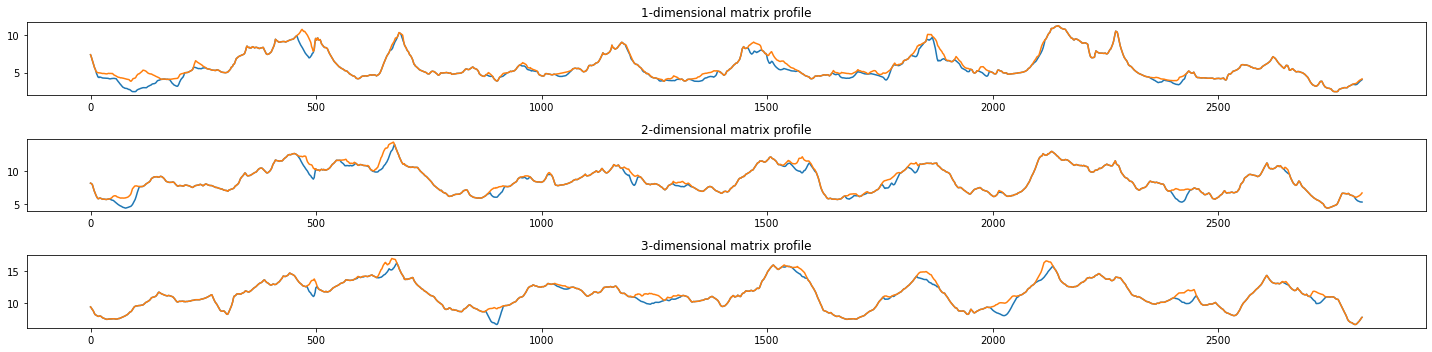

In [54]:
time_series = load_DJIA_stock()
nb_used_dims = 3
time_series = time_series[:nb_used_dims]

sub_len = 200
iter = int(0.8*length-sub_len+1)
mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
mat_pro_approx, _ =  mstamp(time_series, sub_len, iter=iter, random=True)

plt.figure(figsize=(20,5))
for d in range(nb_used_dims):
    min_val = min(mat_pro_ref[d].min(), mat_pro_approx[d].min())
    max_val = max(mat_pro_ref[d].max(), mat_pro_approx[d].max())
    motif_at_ref = mat_pro_ref[d].argsort()[:2]
    motif_at_approx = mat_pro_approx[d].argsort()[:2]
    plt.subplot(nb_used_dims, 1, d+1)
    plt.plot(mat_pro_ref[d])
    plt.plot(mat_pro_approx[d])
    plt.title(f"{d+1}-dimensional matrix profile")
plt.tight_layout()
plt.savefig(f"images/iter80perc_DJIA_3d_sublen{sub_len}.pdf")

The RMSE experience on the Istanbul stock time series shows that the RMSE of the anytime version converges faster than the ordered version only for long enough time series.

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


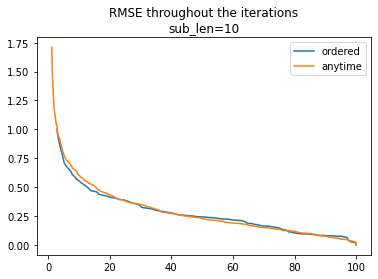

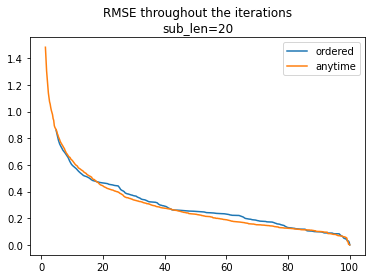

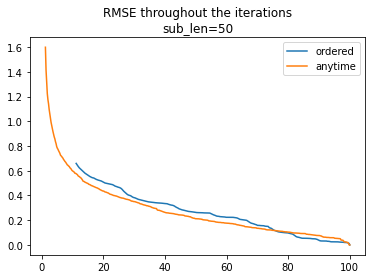

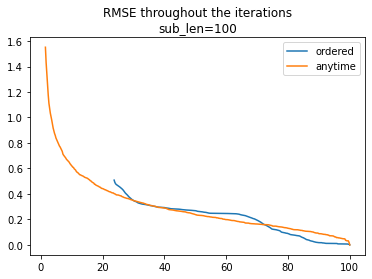

In [95]:
time_series = load_Istanbul_stock()

sub_len = 10
for sub_len in [10, 20, 50, 100]:
    mat_pro_ref, pro_idx_ref = mstamp(time_series, sub_len)
    RMSEs = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=False)
    RMSEs_anytime = compute_mstamp_RMSEs(time_series, sub_len, mat_pro_ref, random=True)

    length = time_series.shape[1]
    perc_iters = np.linspace(1,100,length-sub_len+1)
    max_val = max([RMSEs[RMSEs < np.inf].max(),
                RMSEs_anytime[RMSEs_anytime < np.inf].max()])
    plt.figure()
    plt.title(f"RMSE throughout the iterations\nsub_len={sub_len}")
    plt.plot(perc_iters, RMSEs)
    plt.plot(perc_iters, RMSEs_anytime)
    plt.legend(["ordered", "anytime"])
    plt.show()

# Running time depending on the subsequence length

In [97]:
time_series.shape

(8, 536)

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 10/10 [02:57<00:00, 17.70s/it]


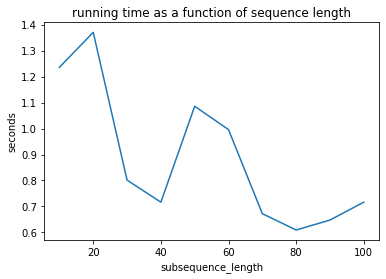

In [99]:
time_series = load_Istanbul_stock()
max_subsequence_length = 100
subsequence_length = np.arange(10, max_subsequence_length+1, 10)
sec = []
nb_simu = 20
for sub in tqdm(subsequence_length):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series, sub)
    tic_out = time.time()
    duration = (tic_out-tic_in)/nb_simu
    sec.append(duration)
plt.plot(subsequence_length, sec)
plt.title("running time as a function of sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("seconds")
plt.show()

100%|██████████| 6/6 [02:18<00:00, 23.12s/it]


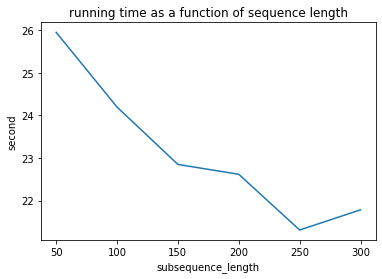

In [125]:
time_series = load_DJIA_stock()
nb_used_dims = 5
time_series = time_series[:nb_used_dims]

max_subsequence_length = 301
subsequence_length = np.arange(50, max_subsequence_length+1, 50)
nb_simu = 10
sec = []
for sub in tqdm(subsequence_length):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series, sub)
    tic_out = time.time()
    duration = (tic_out-tic_in)/nb_simu
    sec.append(duration)
plt.plot(subsequence_length, sec)
plt.title("running time as a function of sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("seconds")
plt.show()

# Running time depending on the time series length

In this experiment, we first use  the DJIA stock time series with only 3 dimensions.
The subsequence length is fixed to $100$, and for each length, we show an average over
20 simulations to increase stability.
Here we observe that the runtime does seem to increase more than linearly in the time series length.
However, we would probably have to take much longer time series to clearly observe the quadratic growth.
Unfortunately, we could not do this experiment, as the computations would be hours long (see Figure 9 of the studied article).



100%|██████████| 11/11 [06:18<00:00, 34.39s/it]


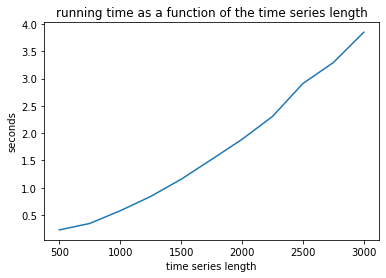

In [64]:
time_series = load_DJIA_stock()
nb_used_dims = 3
time_series = time_series[:nb_used_dims]

lengths = np.arange(500, 3001, 250)
sec = []
sub_len = 100

nb_simu = 20
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series[:,:length], sub_len)
    tic_out = time.time()
    duration = (tic_out-tic_in)/nb_simu
    sec.append(duration)
plt.plot(lengths, sec)
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.savefig(f"images/DJIA_3d_sublen{sub_len}_run_time_by_length_averaged.pdf")

On the Istanbul stock dataset, we can see that the length of the time series is not long enough to observe an asymptotic behavior.


/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 22/22 [05:30<00:00, 15.03s/it]


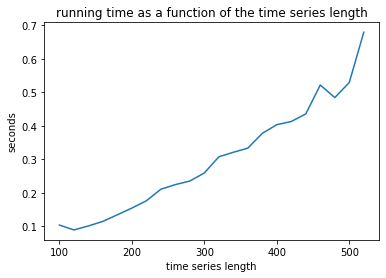

In [66]:
time_series = load_Istanbul_stock()

lengths = np.arange(100, 536, 20)
sec = []
sub_len = 10

nb_simu = 50
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series[:,:length], sub_len)
    tic_out = time.time()
    duration = (tic_out-tic_in)/nb_simu
    sec.append(duration)
plt.plot(lengths, sec)
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.savefig("images/Istanbul_run_time_by_length_averaged.pdf")

# Comparison of the STAMP and STOMP versions of mSTAMP

We first use the DJIA stock dataset with only $10$ dimensions, and compare the runtime of the STAMP and the STOMP versions of mSTAMP for different time series lengths.
For each length, we average over 5 simulations to increase stability.

It is clear that the STOMP version is much faster, with a runtime about half of the STAMP version runtime for each different length.

Warning: the next cell takes about 8 minutes to run.

100%|██████████| 12/12 [08:45<00:00, 43.82s/it]


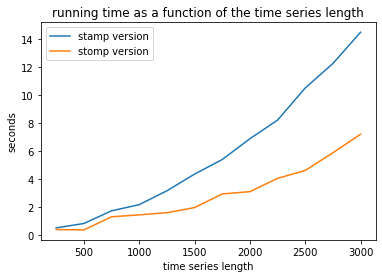

In [103]:
time_series = load_DJIA_stock()
nb_used_dims = 10
time_series = time_series[:nb_used_dims]

lengths = np.arange(250, 3001, 250)
sec_stamp = []
sec_stomp = []
sub_len = 10

nb_simu = 5
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stamp.append(mean_duration)
    
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp_stomp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stomp.append(mean_duration)
plt.plot(lengths, sec_stamp)
plt.plot(lengths, sec_stomp)
plt.legend(["stamp version", "stomp version"])
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.savefig("images/comp_stomp_DJIA_10d.pdf")


We then use the Istanbul stock dataset with all $8$ dimensions.
For each length, we average over 20 simulations to increase stability.

Once again, we observe that the STOMP version is faster, although there is some instability because of the
short total length of the time series.

Warning: the next cell takes about 3 minutes to run.

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 19/19 [03:14<00:00, 10.22s/it]


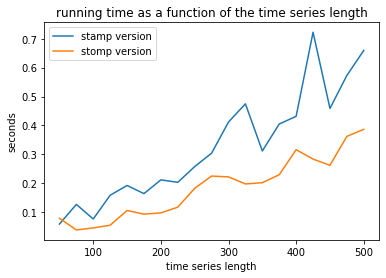

In [104]:
time_series = load_Istanbul_stock()
lengths = np.arange(50, 513, 25)
sec_stamp = []
sec_stomp = []
sub_len = 10

nb_simu = 20
for length in tqdm(lengths):
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stamp.append(mean_duration)
    
    tic_in = time.time()
    for simu in range(nb_simu):
        mat_pro_approx, pro_idx_approx = mstamp_stomp(time_series[:,:length], sub_len)
        tic_out = time.time()
    mean_duration = (tic_out-tic_in)/nb_simu
    sec_stomp.append(mean_duration)
plt.plot(lengths, sec_stamp)
plt.plot(lengths, sec_stomp)
plt.legend(["stamp version", "stomp version"])
plt.title("running time as a function of the time series length")
plt.xlabel("time series length")
plt.ylabel("seconds")
plt.savefig("images/comp_stomp_Istanbul.pdf")

# Running time depending on the dimensionality

We use the DJIA stock dataset with a subsequence length fixed to 50.
To shorten the computations, we only used the first 2000 timestamps
of the time series.
In accordance to the article, we observe a runtime proportional
to the number of dimensions.

100%|██████████| 11/11 [01:59<00:00, 10.85s/it]


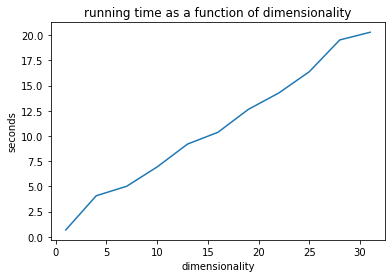

In [108]:
time_series = load_DJIA_stock()
length = 2000
time_series = time_series[:,:length]

sub_len = 50
nb_dims_list = np.arange(1,32,3)
sec = []
for nb_dims in tqdm(nb_dims_list):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(time_series[:nb_dims], sub_len)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(nb_dims_list, sec)
plt.title("running time as a function of dimensionality")
plt.xlabel("dimensionality")
plt.ylabel("seconds")
plt.savefig("DJIA_run_time_by_dim_n2000.pdf")

# MDL-based method

We use the MDL method to select the best dimension $k$ that has a repeated motif. We first display the $\textbf{RDL}$ in bits for the two time series selected by mStamp for every dimension. Then we display the matrix profil for the best dimension according to mdl and we display the dimension selected as well.

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(8, 536)


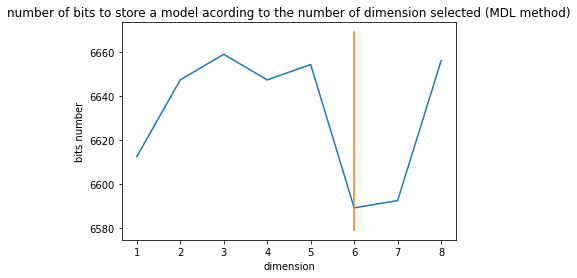

In [17]:
nb_dims = 8
sub_len = 50
time_series = load_Istanbul_stock()
mat_pro, pro_idx, profile = mstamp(time_series[:nb_dims], sub_len, return_dimension=True)
bits = MDL(mat_pro, time_series[:nb_dims].T, sub_len, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)

plt.plot(np.arange(nb_dims) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimension")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

In the following figure we disaply the matrix profile and the dimension selected.

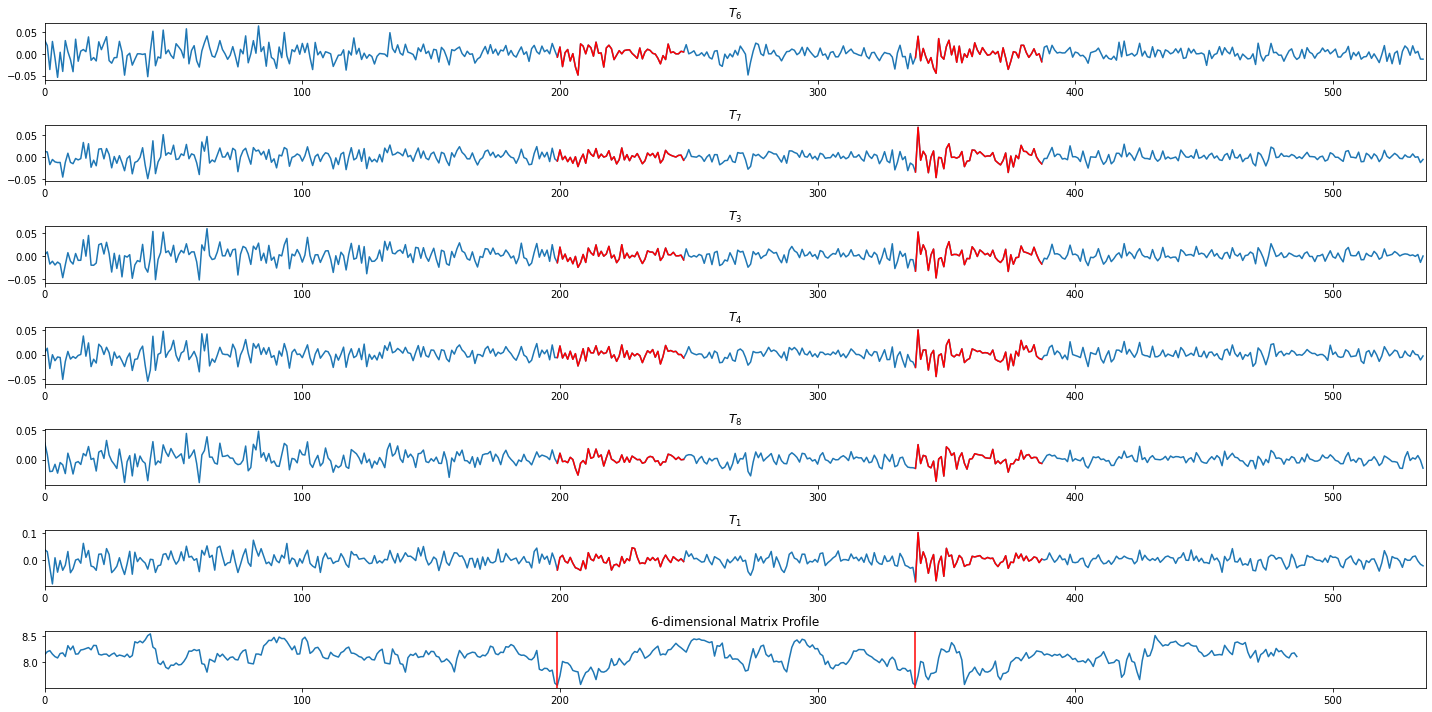

In [16]:
# plot the dimensions selected

plot_motifs(mat_pro, time_series[:nb_dims], sub_len, argmin + 1, profile[argmin])

We then use this dataset with the reference dimension $\{1, 3, 4, 6, 7, 8\}$ and add new irrelevant dimension to see if the MDL base method still manage to find the accurate dimension. The irrelevant dimension are generated with Gaussians.

We first test if the MDL based-method retrieve the right dimension $k$, so here it should be $6$. For each irrelevant dimension we perform $40$ tests.

Progress [##################################################]

Text(0.5, 1.0, 'accuracy according to irrelevant dimension')

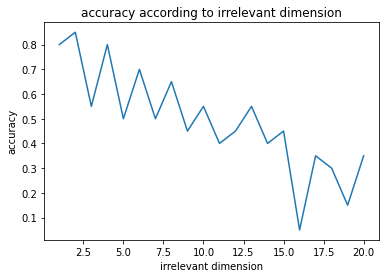

In [63]:
def genereate_noise_time_serie(sigma, n_length, n_irr, data, mean=0):
    """generate a white noise time series of dimension (n_irr, n_length)
    """
    irrelevant_dimensions = np.random.normal(mean, sigma, (n_irr, n_length))
    return np.concatenate((data, irrelevant_dimensions))

# ground truth data
ground_truth = profile[argmin][:, mat_pro[argmin - 1, :].argsort()[:1]]
ground_truth_argmin = argmin
dim, m = time_series.shape
n_test = 20
n_irr = 20

# test the accuracy for the right k
acc_dim_number = []
for i in range(1, n_irr+1):
    print('\rProgress [{0:<50s}]'.format('#' * int(i/n_irr * 50)), end="")
    accuracy = 0
    for j in range(n_test):
        noisy_series = genereate_noise_time_serie(1, m, i, time_series)
        mat_pro, pro_idx, profile = mstamp(noisy_series, sub_len, return_dimension=True)
        bits = MDL(mat_pro, noisy_series.T, sub_len, profile)
        argmin = np.argmin(bits)
        if argmin == ground_truth_argmin:
            accuracy += 1
    acc_dim_number.append(accuracy/n_test)
plt.plot(np.arange(n_irr)+1, acc_dim_number)
plt.xlabel("irrelevant dimension")
plt.ylabel("accuracy")
plt.title("accuracy according to irrelevant dimension")

The MDL accuracy decreases a lot with the irrelevant dimension which is not the case in the article.

We test now the accuracy for a fixed dimension of correct the dimensions (for exemple $T_1, T_3...$) selected by $\textit{mStamp}$.

Progress [                                                  ]

Text(0.5, 1.0, 'accuracy according to irrelevant dimension')

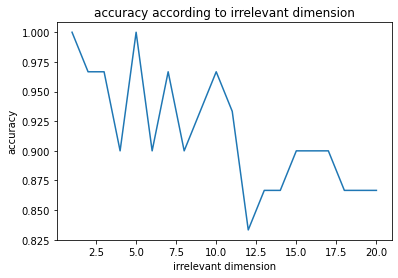

In [64]:
n_irr = 20
n_test = 5

# test the accuracy for the right number of su-dimensions selected for a fixed k => profile accuracy
acc_dim_selected = []
for i in range(1, n_irr+1):
    print('\rProgress [{0:<50s}]'.format('#' * int((i-50)/n_irr * 50)), end="")
    acc_mean = 0
    for j in range(n_test):
        accuracy = 0
        noisy_series = genereate_noise_time_serie(1, m, i, time_series)
        mat_pro, pro_idx, profile = mstamp(noisy_series, sub_len, return_dimension=True)
        dimensions_selected = profile[ground_truth_argmin][:, mat_pro[ground_truth_argmin - 1, :].argsort()[:1]]
        for t in dimensions_selected:
            if t in ground_truth:
                accuracy += 1
        acc_mean += accuracy/(ground_truth_argmin+1)
    acc_dim_selected.append(acc_mean/n_test)
plt.plot(np.arange(n_irr)+1, acc_dim_selected)
plt.xlabel("irrelevant dimension")
plt.ylabel("accuracy")
plt.title("accuracy according to irrelevant dimension")

We have the same conclusion than previously, but the accuracy is better overall.